In [1]:
]activate ../.

  Activating project at `~/.julia/dev/SEM`


In [2]:
using SEM
using LinearAlgebra, Plots, UnPack, Setfield
using Zygote, Flux
using Statistics

# Forward Solve

First lets look at setting up a forwards solution.

We'll be looking at the Poisson equation:

$$\Large -\nu \nabla^2 u = f$$

We'll use the `Diffusion` type from `SEM.jl` to solve this equation.

Let's start by defining a mesh.

Here we create a 16 x 16 linear element grid with non-periodic boundaries.

In [3]:
Ex = 16; nr1 = 2;
Ey = 16; ns1 = 2;

ifperiodic = [false,false]
m1 = Mesh(nr1,ns1,Ex,Ey,ifperiodic)
;

Now let's set the 4 boundaries to Dirichlet conditions, and define functions that return the initial conditions, boundary values, forcing function $f$, and viscosity/conductivity $\nu$

In [4]:
bc = ['D','D','D','D']

setIC(u,x,y,t) = 0.0 .*u
setBC(ub,x,y,t) = @. 0+0*x
setForcing(f,x,y,t) = @. 1+0*x
setVisc(ν,x,y,t) = @. 1+0*x
;

We create a `DiffusionScheme`, which holds all the functions used inside the solver. The reason for this is that each one can be modified by the user, as we will see in the examples.

Then we use `Diffusion` to hold all the relevant data for solving the problem.

In [5]:
sch = DiffusionScheme(setIC,setBC,setForcing,setVisc)
dfn = Diffusion(bc,m1,sch,Tf=0.0,dt=0.00)
;

Finally, we solve with `sim!`.

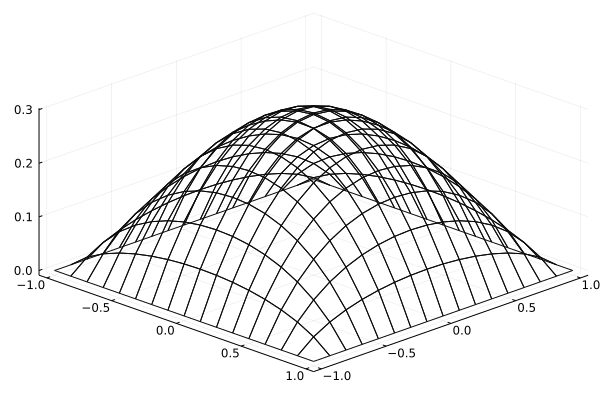

In [6]:
sim!(dfn)
utrue = dfn.fld.u

meshplt(utrue,m1)

# Adjoint Optimization

An adjoint implementation of the matrix-free solver, along with Zygote's autodiff make possible gradient-based optimization of (nearly) any aspect of the solver, from equation parameters to entire solution step surrogates.

## Learning equation parameters

Here, we'll learn the simple scalar $\nu$ from our Poisson equation:

$$\Large -\nu \nabla^2 u = f$$

The true value is 1, from our previous forward solution.

We initialize our model $\nu$ to 2, and define a new viscosity function that uses our scalar parameter.

Change the scheme to reflect the new function and create a new `Diffusion` object.

In [7]:
p0_ν = [2.]
learnVisc(ν,x,y,t) = @. p0_ν+0*x

sch_ν = @set sch.setVisc = learnVisc
dfn_ν = Diffusion(bc,m1,sch_ν,Tf=0.0,dt=0.00)
;

Define model and loss functions, using the true solution from the forward solve.

In [8]:
function model()
    sim!(dfn_ν)
    upred = dfn_ν.fld.u
end

function loss()
    upred = model()
    mean(abs2,upred.-utrue)
end
;

We'll optimize the value of $\nu$ with `Flux.train!` and and arbitrary optimizer. 

We can differentiate via the implicit parameter `ps`. 

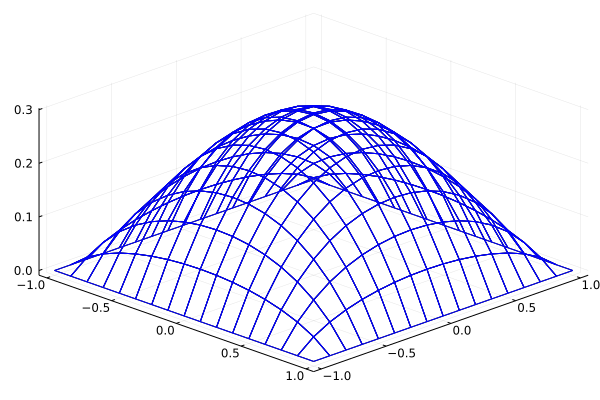

loss() = 2.3203416233173405e-9
p0_ν = [0.9997072729475509]


In [9]:
function cb()
    @show loss()
    plt = meshplt(utrue,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_ν])
opt = ADAM(1e-2)
Flux.train!(loss,ps,Iterators.repeated((), 200),opt, cb = Flux.throttle(cb,.5))
plt = meshplt(utrue,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); display(plt)
@show loss()
@show p0_ν
;

## Learning the source field

Let's try something a little more interesting. This time we'll learn the entire field $f$ on our discrete mesh.

$$\Large -\nu \nabla^2 u = f$$

We'll make the forcing function more interesting too and generate a new true solution

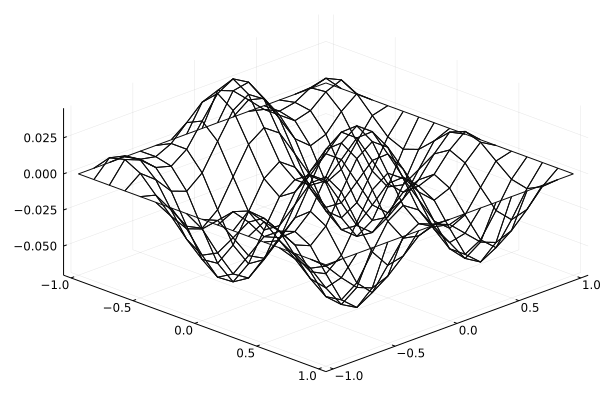

In [10]:
sinForcing(f,x,y,t) = @. sin(2*pi*x)+cos(2*pi*y)
sch2 = @set sch.setForcing = sinForcing
dfn = Diffusion(bc,m1,sch2,Tf=0.0,dt=0.00)

sim!(dfn)
utrue2 = dfn.fld.u
meshplt(utrue2,m1)

The setup is the same as for learning $\nu$, except this time we'll make `p0_f` an array.

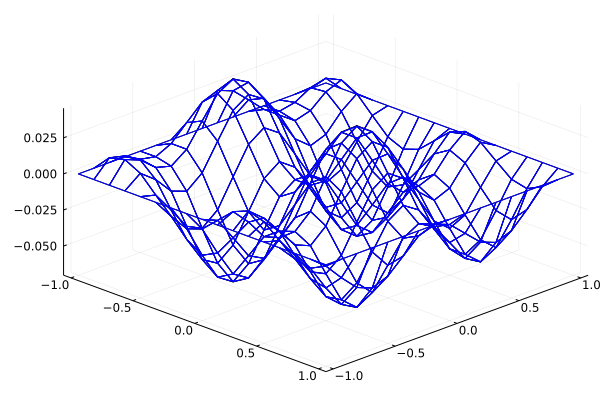

loss() = 4.384377555525037e-9


In [11]:
p0_f = .1 .*ones(size(dfn.f)...)
learnForce(f,x,y,t) = p0_f

sch_f = @set sch.setForcing = learnForce
dfn_f = Diffusion(bc,m1,sch_f,Tf=0.0,dt=0.00)

function model()
    sim!(dfn_f)
    upred = dfn_f.fld.u
end

function loss()
    upred = model()
    mean(abs2,upred.-utrue2)
end

function cb()
    @show loss()
    plt = meshplt(utrue2,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_f])
opt = ADAM(5e-2)
Flux.train!(loss,ps,Iterators.repeated((), 500),opt, cb = Flux.throttle(cb,1))
plt = meshplt(utrue2,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); display(plt)
@show loss()
;

## Optimizing the mesh

Other aspects of the solver are differentiable as well, including the discretization.

In this toy example, we'll apply a constant source to half the domain where $x>0$, and see if the model can deform the mesh to avoid the external forcing.

In [12]:
stepForcing(f,x,y,t) = @. 1*(x>0) + 0*x
sch_m = @set sch.setForcing = stepForcing
;

We need to define a function that takes in the mesh defined on 
$$-1\leq x \leq 1$$ 
$$-1\leq y \leq 1$$
and deforms it to 
$$-1\leq x \leq b$$ 
$$-1\leq y \leq 1$$
The function can be passed when generating the mesh.

In [13]:
b = [1.]
function deform(x,y)
    x = x.*(b.+1)./2 .-(-(b.+1)./2 .+1)
    return x,y
end
;

This time, we will have to generate the mesh and therefore the `Diffusion` object inside `model()`.

We can minimize the integral of the temperature field.

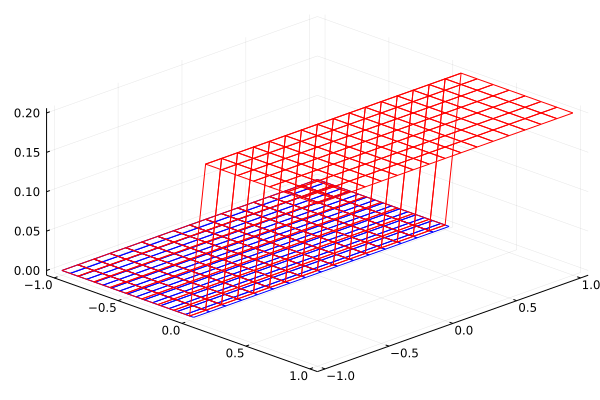

loss() = 0.0


In [14]:
function model()
    m2 = Mesh(nr1,ns1,Ex,Ey,ifperiodic,deform)
    dfn_m = Diffusion(bc,m2,sch_m,Tf=0.0,dt=0.00)
    sim!(dfn_m)
    upred = dfn_m.fld.u
    return upred, m2, dfn_m
end

function loss()
    upred = model()[1]
    sum(abs2,upred)
end

function cb()
    @show loss()
    up,m,d = model()
    plt = meshplt(up,m,c=:blue); plt = meshplt!(m1.x,m1.y,0.2 .*stepForcing(1,m1.x,m1.y,1),c=:red); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([b])
opt = ADAM(5e-3)
Flux.train!(loss,ps,Iterators.repeated((), 200),opt, cb = Flux.throttle(cb,.2))
opt = ADAM(2e-2)
Flux.train!(loss,ps,Iterators.repeated((), 50),opt, cb = Flux.throttle(cb,.2))
up,m,d = model()
plt = meshplt(up,m,c=:blue); plt = meshplt!(m1.x,m1.y,0.2 .*stepForcing(1,m1.x,m1.y,1),c=:red); display(plt) 
@show loss()
;

## Learning the discrete differential operator

All of the solver's internals are accessible via `DiffusionScheme`, including the LHS operator used in the linear solver.

In the linear FEM case, the differential operator is given exactly by convolution with the 2nd order finite-differencing Laplace kernel:
$$
\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{bmatrix}
$$

We can learn this kernel with a convolutional `Flux` layer.

Some helper functions to transform the field between the local element representation and the global representation, where we can use the convolutional layer. 

In [15]:
l2g(u,msh) = ABu(msh.Qy',msh.Qx',msh.mult.*u)
g2l(u,msh) = ABu(msh.Qy,msh.Qx,u)
;

Define the `Flux` model as a single 3x3 layer. For demonstration purposes, we give it a head start by perturbing the true kernel.

In [16]:
oper = Conv((3,3),1=>1,pad=1,stride=1,bias=false)
oper.weight[:,:,1,1].=-[0 1 0;1 -4 1;0 1 0].+1
p0_lap,re_lap = Flux.destructure(oper)
;

`DiffusionScheme.opLHS` accepts a `Diffusion` type and returns the LHS operator function and its arguments.

In [17]:
function lapLearn(dfn::Diffusion)
    
    function opL(u,p0_lap,ν,msh)
        lhs = u.*ν
        lhs = l2g(lhs,msh)
        lhs = re_lap(p0_lap)(reshape(lhs,size(lhs)...,1,1))[:,:,1,1]
        lhs = g2l(lhs,msh).*msh.mult
        return lhs
    end
    
    return opL, (p0_lap,dfn.ν,dfn.msh)
end
;

In this case, we'll train on multiple data points parameterized by the forcing function frequency coefficients `a` and `b`

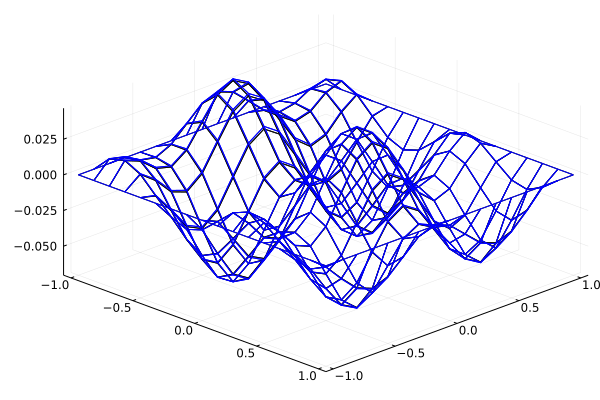

loss(test_data...) = 3.940761977929192e-7
kernel = 
  0.010812639258801937  -1.0004005432128906   0.010812639258801937
 -1.0019729137420654     3.9868924617767334  -1.0019729137420654
  0.002565663540735841  -1.0092575550079346   0.002565663540735841

In [18]:
function trueU(a,b)
    varForcing(f,x,y,t) = @. sin(2*pi*x*a)+cos(2*pi*y*b)
    s = @set sch.setForcing = varForcing
    d = Diffusion(bc,m1,s,Tf=0.0,dt=0.00)
    sim!(d)
    utrue = d.fld.u
end

function model(a,b)
    varForcing(f,x,y,t) = @. sin(2*pi*x*a)+cos(2*pi*y*b)
    sch_lap = @set sch.opLHS = lapLearn
    sch_lap = @set sch_lap.setForcing = varForcing
    dfn_lap = Diffusion(bc,m1,sch_lap,Tf=0.0,dt=0.00)
    sim!(dfn_lap)
    upred = dfn_lap.fld.u
end

function loss(data...)
    upred = model(data...)
    utrue = trueU(data...)
    mean(abs2,upred.-utrue)
end

function cb()
    @show loss(test_data...)
    plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue);
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_lap])
data = [(rand(),rand()) for i=1:1000]
test_data = (1,1)
opt = ADAM(1e-3)
Flux.train!(loss,ps,data,opt, cb = Flux.throttle(cb,2))
plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue); display(plt)
@show loss(test_data...)
println("kernel = ")
Base.print_matrix(stdout, re_lap(p0_lap).weight[:,:,1,1].|>Float64)

## Creating a surrogate solver

We can take things further by bypassing the linear solver completely. Instead of learning the differential operator $D$ given by

$$\Large -\nu D( u ) = f$$

we can learn a surrogate $G$ for the solution $u$

$$\Large u = G(f,\nu)$$

We'll start with a small 2-layer CNN as a surrogate model:

In [19]:
m = Chain(Conv((3,3),1=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>1,pad=1,stride=1))
p0_so,re_so = Flux.destructure(m)
;

Now, we redefine `DiffusionScheme.solve!` with `opLearn!` to use our CNN on the RHS (in its global representation). 

In [20]:
function opLearn!(dfn::Diffusion)
    @unpack rhs,ν,msh,fld = dfn
    @unpack u,ub = fld

    rhs = l2g(rhs./ν,msh)
    u = re_so(p0_so)(reshape(rhs,size(rhs)...,1,1))[:,:,1,1]
    u = g2l(u,msh)
    u = mask(u,fld.M)

    u = u + ub
    @pack! dfn.fld = u
    return
end
;

We'll limit the scope of our surrogate by reducing the span of the training data frequency coefficients.

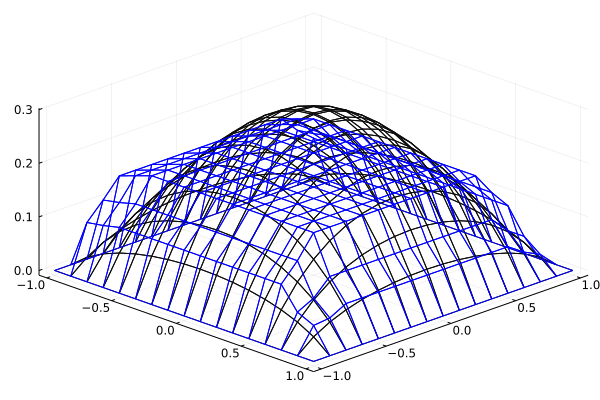

loss(test_data...) = 0.0024732334190044843


In [21]:
function model(a,b)
    varForcing(f,x,y,t) = @. sin(2*pi*x*a)+cos(2*pi*y*b)
    sch_so = @set sch.solve! = opLearn!
    sch_so = @set sch_so.setForcing = varForcing
    dfn_so = Diffusion(bc,m1,sch_so,Tf=0.0,dt=0.00)
    sim!(dfn_so)
    upred = dfn_so.fld.u
end

function loss(data...)
    upred = model(data...)
    utrue = trueU(data...)
    mean(abs2,upred.-utrue)
end

function cb()
    @show loss(test_data...)
    plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue);
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_so])
data = [(.3*rand(),.3*rand()) for i=1:1000]
test_data = (.0,.0)
opt = ADAM(1e-3)
Flux.train!(loss,ps,data,opt, cb = Flux.throttle(cb,2))
plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue); display(plt)
@show loss(test_data...)
;


If you notice, we have a flat spot in the middle of our prediction. This is because the shallow CNN is unable to propagate the boundary information further inwards. Let's mitigate this with a deeper network.

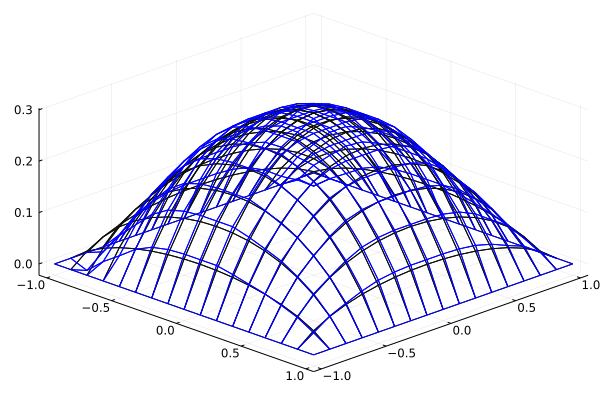

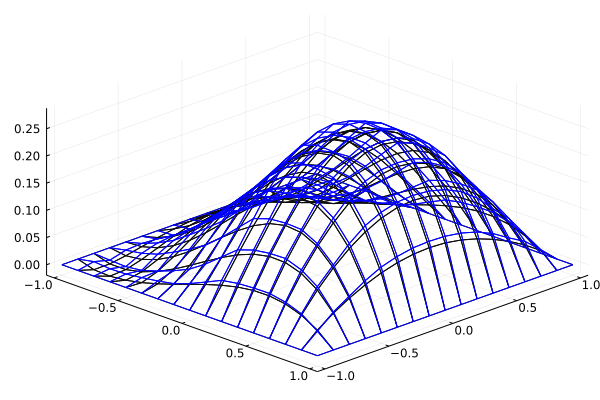

loss(test_data...) = 7.82255864449405e-5
loss(0.3, 0.3) = 6.665725164351234e-5


In [22]:
m = Chain(Conv((3,3),1=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>1,pad=1,stride=1))
p0_so,re_so = Flux.destructure(m)

ps = Params([p0_so])
opt = ADAM(1e-3)
Flux.train!(loss,ps,data,opt, cb = Flux.throttle(cb,2))
plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue); display(plt)
@show loss(test_data...)
plt = meshplt(trueU(.3,.3),m1); plt = meshplt!(m1.x,m1.y,model(.3,.3),c=:blue); display(plt)
@show loss(.3,.3)
;